## Construct PSF (fwhm, ellipticity) grids for a given RA,DEC and image_size 

### Compare PSF grids between different visits, default coadd and customized coadd.
### Compare between different bands

In [1]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt      
%matplotlib inline

# Rubin TAP service utilities
import lsst.geom as geom
import lsst.afw.display as afwDisplay  # for image visualization
import lsst.afw.table as afwTable
from lsst.daf.butler import Butler # access to LSST data products
import lsst.daf.base as dafBase
afwDisplay.setDefaultBackend('matplotlib')

# pipeline tasks 
from lsst.pipe.tasks.calibrate import CalibrateTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
from lsst.meas.algorithms import SourceDetectionTask, SourceDetectionConfig

import warnings
from astropy.units import UnitsWarning
warnings.simplefilter("ignore", category=UnitsWarning)
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

In [2]:
repo = 's3://butler-us-central1-dp01'
collection = '2.2i/runs/DP0.1'
butler = Butler(repo, collections=collection)

In [3]:
def PSF_char(ima, xp, yp):
    point = geom.Point2D(yp, xp)
    sigma = ima.getPsf().computeShape(point).getDeterminantRadius()
    pixelScale = ima.getWcs().getPixelScale().asArcseconds()
    fwhm = 2 * np.sqrt(2. * np.log(2)) * sigma * pixelScale
    return fwhm

### Select image (CUTOUT) for specific RA, DEC and filter

In [4]:
def cutout_coadd(butler, ra, dec, band='g', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given afw SpherePoint radec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Client providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, degrees
    dec: float
        Declination of the center of the cutout, degrees
    filter: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Side of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """

    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize//2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox':bbox}

    cutout_image = butler.get(datasetType, parameters=parameters, dataId=coaddId)

    return cutout_image

In [6]:
def PSFgrid_cutout(ra, dec, filt, ima_size_pix, grid_size_pix):

    ima = cutout_coadd(butler, ra, dec, band=filt, datasetType='deepCoadd', cutoutSideLength=ima_size_pix)
    xMinCutout, yMinCutout = ima.getBBox().getMin()
    xMaxCutout, yMaxCutout = ima.getBBox().getMax()
    
    x = np.arange(xMinCutout, xMaxCutout, grid_size_pix)
    y = np.arange(yMinCutout, yMaxCutout, grid_size_pix)
    x_center = 0.5 * (x[:-1] + x[1:])
    y_center = 0.5 * (y[:-1] + y[1:])
    X, Y = np.meshgrid(x_center, y_center)

    Z = []
    for iy in Y:
        for iiy in iy:
            sx = []
            for iix in X[0]:
                sx.append(PSF_char(ima, iiy, iix))
        Z.append(sx)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    plt.sca(ax[0])  
    display1 = afwDisplay.Display(frame=fig)
    display1.scale('linear', 'zscale')
    display1.mtv(ima.image)
    display1.show_colorbar(False)
    ax[0].axis('off')

    plt.sca(ax[1])
    display2 = afwDisplay.Display(frame=fig)
    plot = plt.pcolormesh(X, Y, Z, cmap='cool', shading='flat')
    bar = plt.colorbar(plot)
    bar.set_label('FWHM [asec]')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()
### include 'arcseconds' in the color bar label

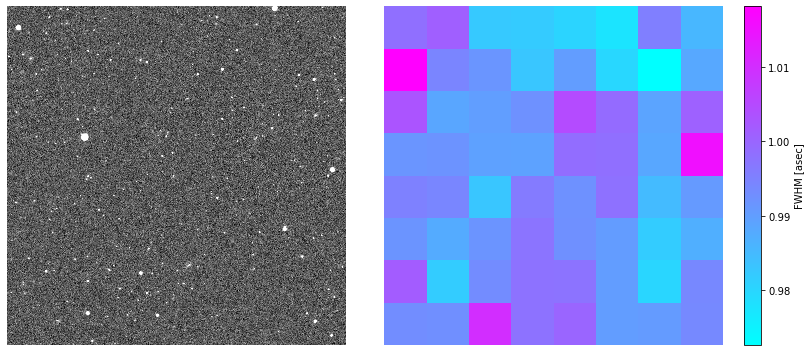

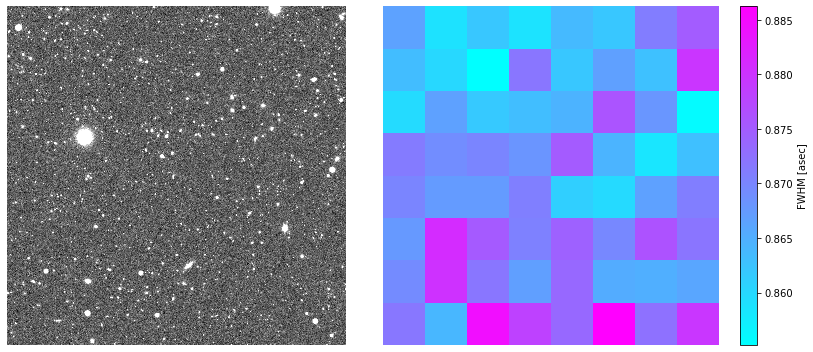

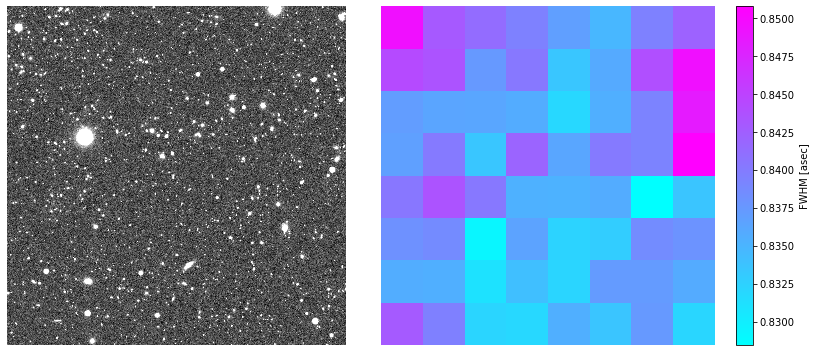

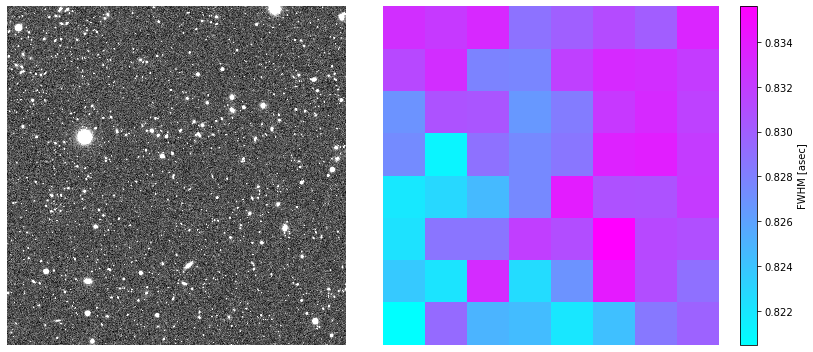

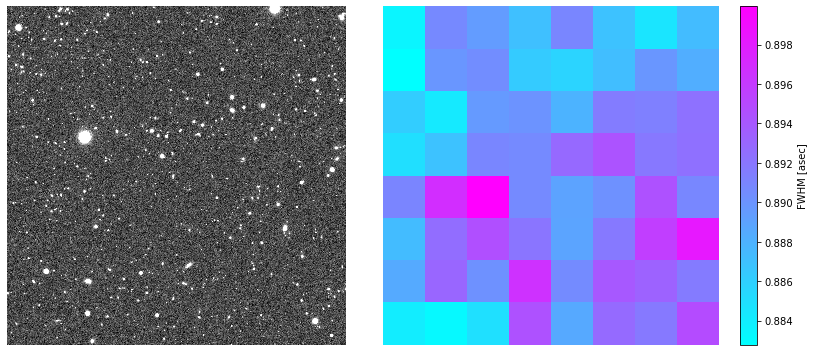

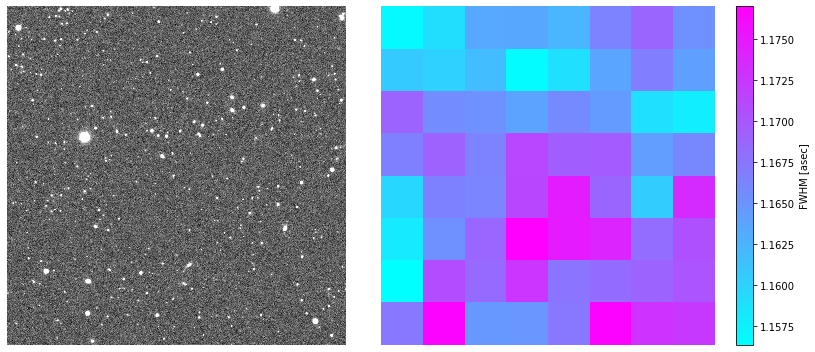

In [7]:
for f in ('u','g', 'r', 'i', 'z', 'y'):
    PSFgrid_cutout(55.064, -29.783, f, 2000, 200)